#Assignment 6: Q-Learning
##Task 2. Laberinto de cuartos
Laura Quiroga - 201922965

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

#Definición del ambiente

In [ ]:
class Environment:
  def __init__(self, exit, states=[]):
    self.board = states
    self.rewards = np.zeros_like(self.board, dtype=float)
    self.exit_state = (exit[0][0]-1, exit[0][1]-1)
    self.exit_action = exit[1]

    for x in range(len(self.board)):
      for y in range(len(self.board[0])):
        if self.board[x][y]=='e':
          self.rewards[x][y]=-1


  def start(self):
    """
    Devuelve una casilla de inicio válida
    """
    valida = False
    state = (0,0)
    while not valida:
      x = np.random.randint(len(self.board))
      y = np.random.randint(len(self.board[0]))
      if self.board[x][y]!='g' and self.board[x][y]!='o':
        state = (x,y)
        valida = True
    return state
  
  def dim(self): 
    """
    Devuelve tamanio del tablero
    """
    return [len(self.board), len(self.board[0])]

#Definición del agente

In [ ]:
class Agent:
    def __init__(self, init_state):
      self.state = init_state
      self.actions = ['up', 'right', 'down', 'left']
      
    def reset(self, init_state):
      """
      Lleva al agente a la posición inicial
      """
      self.state = init_state

    def  set_state(self, next_state):
      """
      Actualiza el estado actual del agente
      """
      self.state = next_state
  

#Definición de la clase intermediaria

In [ ]:
#Clase que media la interacción entre el agente y su entorno
#Así nos aseguramos de que el agente no conozca lo que no debe conocer de su entorno

class Learner:
    def __init__(self, agent, env, alpha=0.5, gamma=0.6, epsilon=0.1):
      #hyper parameters
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon = epsilon
      self.env = env
      self.agent = agent          #actual agent
      self.qtable = self.__initdic__() #rewards table
      #initiate random policy
      self.policy = [[np.random.randint(len(self.agent.actions)) for y in range(self.env.dim()[1])] for x in range(self.env.dim()[0])]
    
    def __initdic__(self):
      """
      Inicializa la q-tabla en 0s 
      Dim: x,y,actions
      """
      table = np.zeros((self.env.dim()[0], self.env.dim()[1], len(self.agent.actions)), dtype=object)
      return table


    def run(self):
      print(self.policy)
      done = False
      while not done:
          current_state = self.agent.state

          # Con prob epsilon: toma acción aleatoria
          if random.uniform(0,1) < self.epsilon:
              action = self.randomAction()
          # Con prob 1-epsilon: toma mejor acción según q-tabla
          else:
              action = self.choose_best_action(current_state)

          next_state, reward, done, info = self.step(action)
          old_value = self.qtable[current_state[0],current_state[1]][action]
          if not next_state is None:
            next_max = np.max(self.qtable[next_state[0], next_state[1]])
          else:
            next_max = reward

          #compute q_value(s, a, t): (1-alpha) *q_value(s, a, t-1)+ apha*(r + gamma * max_q_value(s', t))
          new_value = (1 - self.alpha)*old_value + self.alpha*(reward + self.gamma*next_max)
          self.qtable[current_state[0],current_state[1]][action] = new_value

          #print(info) #formated result
          #print(f'{current_state}, {action}, {next_state}')
      new_policy = self.calculate_policy()
      converged = self.check_convergence(new_policy)
      self.policy = new_policy
    
      return converged

    
    def calculate_policy(self):
      """
      Calcula la política para cada estado
      """
      policy = np.zeros((self.env.dim()[0], self.env.dim()[1]), dtype=object)
      for x in range(self.env.dim()[0]):
        for y in range(self.env.dim()[1]):
          policy[x][y]=self.choose_best_action((x,y))
      return policy

    def check_convergence(self, new_policy)->bool:
      converged = True
      for x in range(self.env.dim()[0]):
        for y in range(self.env.dim()[1]):
          if self.policy[x][y]!=new_policy[x][y]:
            return False
      return converged

    def randomAction(self):
      return random.randint(0,len(self.agent.actions)-1)
    
    def choose_best_action(self, current_state):
      """
      Escoge la mejor acción según los valores de la q_tabla
      Si hay empate, escoge aleatoriamente entre las acciones óptimas
      """
      q_values = self.qtable[current_state[0], current_state[1]]
      max_q_value = -math.inf
      best_actions = []
      for i in range(len(q_values)):
        if q_values[i]>max_q_value:
          max_q_value = q_values[i]
          best_actions.clear()
          best_actions.append(i)
        elif q_values[i]==max_q_value:
          best_actions.append(i)
      if self.policy[current_state[0]][current_state[1]] in best_actions:
        return self.policy[current_state[0]][current_state[1]]
      return np.random.choice(best_actions)

    def step(self, i_action):
      """
      Ejecuta la acción dada a partir del estado actual del agente
      """
      old_state = self.agent.state
      action = self.agent.actions[i_action]
      next_state, reward, done = self.takeAction(old_state, action)

      info = f'Executed action: {action}. From {old_state} to {next_state}. Reward: {reward} Terminal: {done}'
      return next_state, reward, done, info

    def takeAction(self, state, action):
      max_x = self.env.dim()[0]-1
      max_y = self.env.dim()[1]-1
      done = False

      #salida
      if state == self.env.exit_state and action==self.env.exit_action:
        next_state = None
        done = True
        reward = 1

      else:
        if action == "up":
          next_state = (state[0], max(state[1]-1, 0))
        elif action == "down":
          next_state = (state[0], min(state[1]+1, max_y))
        elif action == "left":
          next_state = (max(state[0]-1,0), state[1])
        else:
          next_state = (min(state[0]+1, max_x), state[1])

        #si la casilla nueva no es pisable ->next_state=state
        if self.env.board[next_state[0]][next_state[1]]=='o':
          next_state=state

        self.agent.set_state(next_state)


        reward = self.env.rewards[next_state[0]][next_state[1]]

      return next_state, reward, done

#Visualización de resulatados

In [ ]:
def find_max (value_list):
  max_value = -math.inf
  best_index = []
  for i in range(len(value_list)):
    if value_list[i]>max_value:
      max_value = value_list[i]
      best_index.clear()
      best_index.append(i)
    elif value_list[i]==max_value:
      best_index.append(i)
  return np.random.choice(best_index)

In [ ]:
def print_table(results):
  print("Q-table\n")
  dimensions = results[1].dim()
  d = dict()
  for x in range(dimensions[0]):
    for y in range(dimensions[1]):
      q_values = [x for x in results[0][x][y]]
      d.update({f'{x+1,y+1}': q_values})
  print ("{:<8} {:<15} {:<15} {:<15} {:<15}".format('State',f'{results[2].actions[0]}',f'{results[2].actions[1]}',
                                             f'{results[2].actions[2]}',f'{results[2].actions[3]}'))
  for k, v in d.items():
    a1, a2, a3, a4 = v
    print ("{:<8} {:<15} {:<15} {:<15} {:<15}".format(k, value_to_str(a1), value_to_str(a2), value_to_str(a3), value_to_str(a4)))

def value_to_str(value)-> str:
  if not value is None:
    return round(value, 6)
  return "None"

def show_results(results):
  n_episodes = results[3]
  #results = (q_tabla, environment, agent)
  dimensions = results[1].dim()
  grid_x=list(range(1,dimensions[0]+1))
  grid_y=list(range(1,dimensions[1]+1))
  fig, ax = plt.subplots()
  
  values = np.zeros((dimensions[1],dimensions[0]))
  actions = np.zeros((dimensions[1],dimensions[0]), dtype=object)

  for x in range(dimensions[0]):
    for y in range(dimensions[1]):
      if results[1].board[x][y] != "o":
        max_q_value = find_max(results[0][x][y])
        if results[1].board[x][y] == "g":
          values[y][x]= None
          actions[y][x] = "Exit"
        else:
          values[y][x]= round(results[0][x][y][max_q_value],4)
          actions[y][x] = (results[2].actions[max_q_value])

      else:
        values[y][x]=None
        actions[y][x]=None

  im = ax.imshow(values)
  ax.set_xticks(np.arange(len(grid_x)), labels=grid_x)
  ax.set_yticks(np.arange(len(grid_y)), labels=grid_y)
  ax.set_title(f"Policy results after evaluation of {n_episodes} episodes")

  # Loop over data dimensions and create text annotations.
  for i in range(len(grid_y)):
      for j in range(len(grid_x)):
        text = ax.text(j, i, f"{str(values[i,j])}\n{actions[i,j]}",
                      ha="center", va="center", color="k")
  plt.clf

  #

  plt.rcParams['figure.figsize'] = [10, 10]
  plt.show()
  plt.clf

  print_table(results)
      


#Ejecución de escenarios de prueba

In [ ]:
def test(states, rewards):

    e = Environment(states, rewards)
    a = Agent(e.start())
    l = Learner(a, e)

    episodes = 0
    convergence_count = 0
    while convergence_count<30:
        print(f"Episode: {episodes+1}")
        converged = l.run()
        if converged:
          convergence_count+=1
        else:
          convergence_count=0
        a.reset(e.start())
        episodes+=1
    return (l.qtable, e, a, episodes)

In [ ]:
#Ejecutar el escenario de prueba 2
states_laberinto = [['e','e','e','e','e','o','e','e','e','e','e'],
                    ['e','e','e','e','e','o','e','e','e','e','e'],
                    ['e','e','e','e','e','e','e','e','e','e','e'],
                    ['e','e','e','e','e','o','e','e','e','e','e'],
                    ['e','e','e','e','e','o','e','e','e','e','e'],
                    ['o','o','e','o','o','o','o','o','e','o','o'],
                    ['e','e','e','e','e','o','e','e','e','e','e'],
                    ['e','e','e','e','e','o','e','e','e','e','e'],
                    ['e','e','e','e','e','e','e','e','e','e','e'],
                    ['e','e','e','e','e','o','e','e','e','e','e'],
                    ['e','e','e','e','e','o','e','e','e','e','e'] ]
exit = [(3,1),'up']
results2 = test(exit, states_laberinto) 

Se han truncado las últimas 5000 líneas del flujo de salida.
 [3 3 3 0 3 1 3 0 0 0 0]
 [3 3 0 0 0 1 3 3 3 3 3]
 [2 1 3 1 2 2 0 1 3 3 0]
 [2 2 3 0 0 0 2 2 3 0 0]
 [2 2 3 0 3 3 1 2 3 3 3]
 [2 2 3 3 0 0 0 0 0 0 0]
 [3 3 3 0 3 0 3 0 3 0 3]
 [3 3 3 0 3 1 3 3 0 0 0]]
Episode: 6499
[[1 1 1 1 0 2 1 1 1 1 0]
 [1 1 0 1 0 2 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [3 3 3 0 3 1 3 0 0 0 0]
 [3 3 0 0 0 1 3 3 3 3 3]
 [2 1 3 1 2 2 0 1 3 3 0]
 [2 2 3 0 0 0 2 2 3 0 0]
 [2 2 3 0 3 3 1 2 3 3 3]
 [2 2 3 3 0 0 0 0 0 0 0]
 [3 3 3 0 3 0 3 0 3 0 3]
 [3 3 3 0 3 1 3 3 0 0 0]]
Episode: 6500
[[1 1 1 1 0 2 1 1 1 1 0]
 [1 1 0 1 0 2 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [3 3 3 0 3 1 3 0 0 0 0]
 [3 3 0 0 0 1 3 3 3 3 3]
 [2 1 3 1 2 2 0 1 3 3 0]
 [2 2 3 0 0 0 2 2 3 0 0]
 [2 2 3 0 3 3 1 2 3 3 3]
 [2 2 3 3 0 0 0 0 0 0 0]
 [3 3 3 0 3 0 3 0 3 0 3]
 [3 3 3 0 3 1 3 3 0 0 0]]
Episode: 6501
[[1 1 1 1 0 2 1 1 1 1 0]
 [1 1 0 1 0 2 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [3 3 3 0 3 1 3 0 0 0 0]
 [3 3 0 0 0 1 3 3 3 3 3]
 [2 1 3 1 2 2 0 1 3

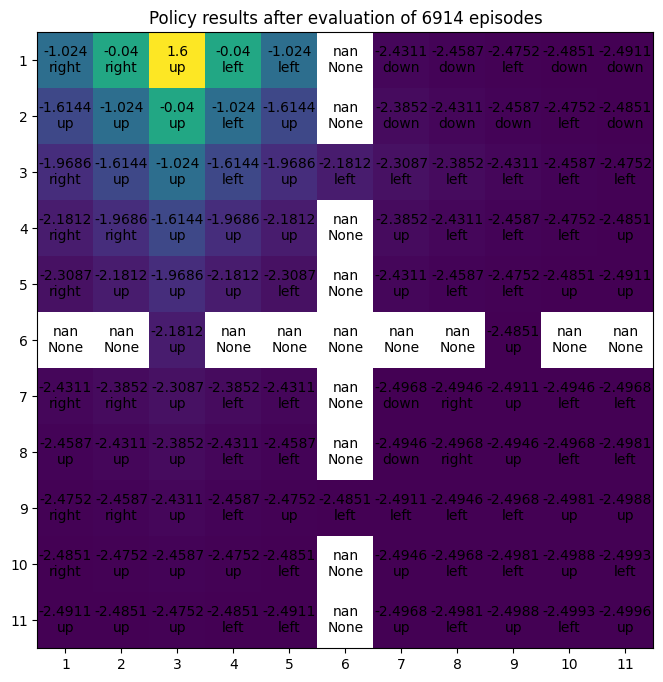

Q-table

State    up              right           down            left           
(1, 1)   -1.531425       -1.024          -1.904141       -1.589548      
(1, 2)   -1.6144         -1.6144         -2.117942       -1.82472       
(1, 3)   -1.96864        -1.96864        -2.295175       -2.147559      
(1, 4)   -2.181184       -2.181184       -2.383098       -2.268852      
(1, 5)   -2.30871        -2.30871        -2.370585       -2.367635      
(1, 6)   0               0               0               0              
(1, 7)   -2.457855       -2.431136       -2.474933       -2.458113      
(1, 8)   -2.458681       -2.458681       -2.483511       -2.47498       
(1, 9)   -2.475209       -2.475209       -2.490353       -2.48301       
(1, 10)  -2.485125       -2.485125       -2.492988       -2.485197      
(1, 11)  -2.491075       -2.491075       -2.493223       -2.493007      
(2, 1)   -1.023968       -0.04           -1.606866       -1.614332      
(2, 2)   -1.024          -1.024          -

In [ ]:
show_results(results2)